# Monte Carlo simulation of SIS epidemic spreading
Monte Carlo simulation of an epidemic spreading dynamics in complex networks, using the SIS model in which each node represents an individual which can be in two possible states: Susceptible (S), i.e., healthy but can get infected; Infected (I), i.e., has the disease and can spread it to its neighbors. <br><br>

We are interested in the calculation of the fraction of infected nodes, ρ, in the stationary state, as a function of the infection probability of the disease β (at least 51 values between β=0 and β=1, Δβ=0.02), for different values of the recovery probability μ (e.g. 0.1, 0.5, 0.9). 


### Import libraries

In [ ]:
!pip install igraph
import igraph as ig
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')
plt.rcParams["figure.figsize"] = (12, 6)

# import cython module for allowing c compilation and static binding to improve the performance
%load_ext cython

Be sure to insall the Cython extension!

## Auxiliary functions

### Simulation function
The function below performs 1 full simulation of SIS epidemic spreading. <br>
Since this function is very expensive and it needs to be called at each performed simulation, we declare it as a c function and we add also some static binding for some of the used variables. <br>
In this way we greatly improve the performance of the algorithm. <br><br>
The simulation function takes in input:
* the graph g and its length
* the array of initial states (randomly generated): it is an array of the same size as the one of the network, where each cell indicates the state of the corresponding node (1 stands for I and 0 stands for S)
* the 2 main paramters of the SIS model, i.e. µ and β

The function performs TMAX iterations and it returns the average of ρ(t) calcualating considering the mean of the ρ values obtained after TTRANS iterations, when we assume that the systems has 
reached the stationary state. <br>

Indeed, the simulation requires also 2 extra parameters:
* TMAX  maximum number of time steps of each simulation
* TTRANS  number of steps of the transitory

In [ ]:
%%cython
import numpy as np
import igraph as ig
from libc.math cimport pow # import C pow function
from libc.stdlib cimport rand, srand, RAND_MAX # import C random functions
from libc.time cimport time,time_t # import C time function

def simulation(g, int len_g, char[:] state, double mu, double beta):
    
    """
    Applies one simulation to the graph in argument and returns 
    the average infection rate over the stationary time steps
    """ 
    
    # Constants
    cdef int TMAX = 1000 # maximum number of time steps of each simulation
    cdef int TTRANS = 900 # number of steps of the transitory
    
    # Declared variables
    cdef double[:] infected_ratio_list = np.zeros(TMAX - TTRANS) # infection ratio at each step of the stationary
    cdef int i, j, v, n # counters
    cdef int infected_vertices # number of infected neighbors
    cdef char[:] old_state = np.zeros(len_g, dtype = np.int8) # array of the states of the nodes in the previous iteration
    cdef double prob # probability value between 0 and 1
    cdef double a = RAND_MAX
    cdef int num_infected = 0 # counter of the number of infected vertices at each time step
    
    # set random seed 
    srand(time(NULL)) 
    
    #simulation loop
    for i in range(TMAX):
        
        if i >= TTRANS:
            num_infected = 0
            
        # copy old state
        for j in range(len_g):
            old_state[j] = state[j]
        
        # update states of all nodes
        for j in range(len_g):
            
            # if old node state is I
            if old_state[j]:
                prob = rand() / a # generate random number in [0, 1]
                if prob < mu: # update new state
                    state[j] = 0 
                else:
                    state[j] = 1
                
            # if old node state is S
            else:
                infected_vertices = 0  # counter of the infected vertices of current SUSCECTIBLE node
                
                for n in g.neighbors(j):
                    infected_vertices += old_state[n]
                prob = rand() / a
                if prob < pow(1 - beta, infected_vertices):
                    state[j] = 0
                else:
                    state[j] = 1
                    
            # we compute infection ratio from iteration 900
            if i >= TTRANS:
                num_infected += state[j]
            
        if i >= TTRANS:
            infected_ratio_list[i - TTRANS] = num_infected/len_g

    # returns the average infected ratio (calculated only over the stationary)    
    return np.mean(np.array(infected_ratio_list)) 

### Perform n simulations

Let's define an auxiliary function for performing NREP simulations


In [ ]:
NREP = 100

In [ ]:
!pip install tqdm
from tqdm.notebook import tqdm
def perform_n_iterations(g, len_g, MU, BETA, n=NREP):
    
    start_t = time.time()
    infected_ratio_list = np.zeros(NREP) # vector with avg infection ratio of each simulation
    
    #for i in tqdm(range(NREP), desc=f'mu={MU}, beta={BETA}'):
    for i in range(NREP):
        
        start_time = time.time()
        state = np.array(np.random.binomial(1, P0, size=len_g), dtype=np.int8) # initial state
        
        infected_ratio_list[i] = simulation(g, len_g, state, MU, BETA)
        #print("Time required by simulation {}: {} seconds".format(i+1, time.time()-start_time))
    #print("\nTime required by {} simulations: {} seconds\n\n".format(n, time.time() - start_t))
    
    return np.mean(infected_ratio_list) # return average of averages over 100 iterations

### Iterate over β
We need now to iterate over different beta values

In [ ]:
def iterate_over_beta(g, len_g, MU, beta_list): # notice that MU is given
    # avg ρ for each β
    avg_over_beta = np.zeros(len(beta_list))
    
    for i, beta in enumerate(tqdm(beta_list, desc=f'Avg betas, mu={mu}')):
        #print("Calculate value for beta = {} (mu = {})".format(beta, MU))
        avg_over_beta[i] = perform_n_iterations(g, len_g, MU, beta, NREP) 
        
    # returns the value for each beta value given the MU value
    return avg_over_beta 

## Microscopic Markov Chain Approach (MMCA) model
Auxiliary function for applying the MMCA approach, which allows to capture the microsopic dynamics at the individual level by computing the probability that any node is infected in the steady state. <br> In particular, we consider a reactive process, i.e. we assume that each node contacts all of his neighbors at each time step, and we formulate the MMCA for the case without one-step reinfections, i.e. only nodes suscetible at the beginning of the time step can be infected. <br>
The MMCA model equation, to be solved iteratively is the following:<br>
<h4><center>pi(t + 1) = (1 − pi(t))(1 − qi(t)) + (1 − μ)pi(t)</center></h4> <br>

Where:
* pi(t) represents the probability of node i being infected at time step i
* qi(t) represents the probability that a node is not being infected by any neighbor

At the end, we'll compare the ρ(β) result from Monte Carlo simulations with the theoretical prediction provided by the Microscopic Markov Chain Approach (MMCA) model. <br>
Again, we use cython to speedup the computation.



In [ ]:
%%cython
import numpy as np
import igraph as ig

def MMCA_model(g, int len_g, double[:] probs, double mu, double beta):
    
    """
    Applies iteratively the MMCA equation to the graph in argument and returns the average infection rate over the last 2 steps
    """ 
    
    # Constants
    cdef int TMAX = 1000 # maximum number of iterations of the equation    
    
    # Declared variables
    cdef int i, j, v # counters
    cdef double[:] old_probs = np.zeros(len_g) # array of node probabilites of being infected in the previous step
    cdef double q_i # probability that a node is not infected by any neighbour
    
    #equation iterations
    for i in range(TMAX):
             
        # copy old probabilities
        for j in range(len_g):
            old_probs[j] = probs[j]
        
        # apply equation to each node
        for j in range(len_g):
            q_i = 1 # initialize q_i
            
            # compute the probability that current node is NOT infected by any neighbor
            for v in g.neighbors(j):
                q_i = q_i * (1 - beta * old_probs[v])
            
            # apply equation to obtain the new probaility of being infected
            probs[j] = (1 - old_probs[j]) * (1 - q_i) + (1 - mu) * old_probs[j]

   
    return ((np.mean(probs) + np.mean(old_probs)) / 2)

In order to perform the calculations over multiple beta values:

In [ ]:
def iterate_over_beta_MMCA(g, len_g, MU, beta_list): # notice that MU is given
    # ρ for each β 
    ro_over_beta = np.zeros(len(beta_list))
    
    for i, beta in enumerate(tqdm(beta_list, desc=f'MMCA')):
        probs = np.full(len_g, P0) # array with initial node probabilities of being infected
        ro_over_beta[i] = MMCA_model(g, len_g, probs, MU, beta)
    # returns the value for each beta value given the MU value
    return ro_over_beta

# Example

## Network

In [ ]:
#len_g = 500
#g = ig.Graph.Barabasi(len_g, 5)
#g = ig.Graph.Erdos_Renyi(n=500, p=0.2)
g = ig.read("CM_powerlaw_gamma2.3_n500.net")
len_g = g.vcount()
net_name = "CM(gamma=2.3, N=500)"
file_name = "CM_powerlaw_gamma2.3_n500"
#g.write_pajek(file_name+".net")

### Some network descriptors
We use networkx

In [ ]:
import networkx as nx

# read the net as a networkx network
#path = os.path.join("nets", network_f, network_name + '.net')
#G = nx.read_pajek(path)

A = g.get_edgelist()
G = nx.Graph(A)

nnodes = G.number_of_nodes()
print("Number of nodes: {}".format(nnodes))
#G.nodes()

print("Number of edges: {}".format(G.number_of_edges()))
#G.edges()

degrees_values = [val for key,val in G.degree()] # degree for each node
#degrees_values

print("Min degree: {}".format(np.min(degrees_values)))
print("Max degree: {}".format(np.max(degrees_values)))
print("Avg degree: {}".format(round(np.mean(degrees_values), 4)))
#G = nx.Graph(G)

print("Clustering: {}".format(round(nx.average_clustering(G), 4)))
print("Assortativity: {}".format(round(nx.degree_assortativity_coefficient(G), 4)))
if nx.is_connected(G):
    print("Avg path length: {}".format(round(nx.average_shortest_path_length(G), 4)))
    print("Diameter: {}".format(nx.diameter(G)))


Number of nodes: 500
Number of edges: 642
Min degree: 1
Max degree: 19
Avg degree: 2.568
Clustering: 0.0081
Assortativity: -0.036


### Plot of the network

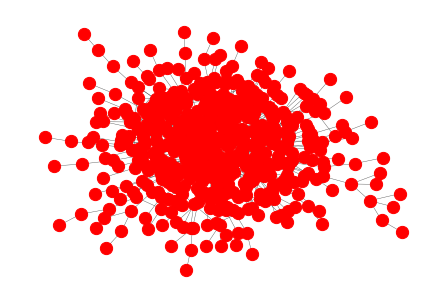

In [ ]:
pos = nx.kamada_kawai_layout(G)
# perform the drawing, by using the node coordinates calculated above

# select node size depending on the network size
if nnodes >= 2000:
    node_size = 30
elif nnodes >= 1000 and nnodes < 2000:
    node_size = 50
elif nnodes >= 500 and nnodes  < 1000:
    node_size =  150
else:
    node_size = 250
    
#p_i = os.path.join("images", network_f, network_name)
#if not os.path.exists(p_i):
#    os.makedirs(p_i)
    
nx.draw(G, pos=pos, node_size=node_size, width=0.4, edge_color='0.3', node_color='red')

#plt.savefig(os.path.join(p_i, network_name + '_intro-plot.png')) # to save the plot

### Save network

In [ ]:
#g.write_pajek("example")

## Simulation

In [ ]:
P0 = 0.2

### Adjust parameters TMAX and TTRANS by performing a simulation
For these two parameters it would be better to adjust them using a simulation: we plot 
ρ(t) to be sure that, after TTrans time steps, the value of ρ has not a clear tendency to 
increase or decrease, despite the oscillations due to the stochastic nature of the 
simulation process.


In [ ]:
# TODO

### Lists

In [ ]:
STEP_BETA = 0.02

mu_list = [0.1, 0.5, 0.9]
beta_list = np.arange(0.00, 1.00, STEP_BETA)

In [ ]:
len(beta_list) # SHOULD BE AT LEAST 51 VALUES WITH deltaB = 0.02

50

In [ ]:
beta_list

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98])

### Perform the simulation

In [ ]:
values_per_mu = []
values_per_mu_MMCA = []
start_time = time.time()

for mu in tqdm(mu_list, desc='General progress bar'):
    print("Computing value for mu = {}\n".format(mu))
    values_per_mu.append(iterate_over_beta(g, len_g, mu, beta_list)) 
    values_per_mu_MMCA.append(iterate_over_beta_MMCA(g, len_g, mu, beta_list))
    
print("Total required time: {} seconds".format(time.time() - start_time))

General progress bar:   0%|          | 0/3 [00:00<?, ?it/s]

Avg betas, mu=0.1:   0%|          | 0/50 [00:00<?, ?it/s]

mu=0.1, beta=0.0:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.02:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.04:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.06:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.08:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.1:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.12:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.14:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.16:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.18:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.2:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.22:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.24:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.26:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.28:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.3:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.32:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.34:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.36:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.38:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.4:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.42:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.44:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.46:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.48:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.5:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.52:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.54:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.56:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.58:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.6:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.62:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.64:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.66:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.68:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.7000000000000001:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.72:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.74:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.76:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.78:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.8:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.8200000000000001:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.84:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.86:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.88:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.9:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.92:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.9400000000000001:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.96:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.98:   0%|          | 0/100 [00:00<?, ?it/s]

MMCA:   0%|          | 0/50 [00:00<?, ?it/s]

Avg betas, mu=0.5:   0%|          | 0/50 [00:00<?, ?it/s]

mu=0.5, beta=0.0:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.02:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.04:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.06:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.08:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.1:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.12:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.14:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.16:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.18:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.2:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.22:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.24:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.26:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.28:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.3:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.32:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.34:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.36:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.38:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.4:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.42:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.44:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.46:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.48:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.5:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.52:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.54:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.56:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.58:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.6:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.62:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.64:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.66:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.68:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.7000000000000001:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.72:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.74:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.76:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.78:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.8:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.8200000000000001:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.84:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.86:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.88:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.9:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.92:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.9400000000000001:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.96:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.98:   0%|          | 0/100 [00:00<?, ?it/s]

MMCA:   0%|          | 0/50 [00:00<?, ?it/s]

Avg betas, mu=0.9:   0%|          | 0/50 [00:00<?, ?it/s]

mu=0.9, beta=0.0:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.02:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.04:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.06:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.08:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.1:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.12:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.14:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.16:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.18:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.2:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.22:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.24:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.26:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.28:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.3:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.32:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.34:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.36:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.38:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.4:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.42:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.44:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.46:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.48:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.5:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.52:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.54:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.56:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.58:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.6:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.62:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.64:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.66:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.68:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.7000000000000001:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.72:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.74:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.76:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.78:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.8:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.8200000000000001:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.84:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.86:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.88:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.9:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.92:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.9400000000000001:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.96:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.98:   0%|          | 0/100 [00:00<?, ?it/s]

MMCA:   0%|          | 0/50 [00:00<?, ?it/s]

Total required time: 1885.9575262069702 seconds


In [ ]:
values_per_mu

[array([0.       , 0.       , 0.1625968, 0.3011596, 0.3844336, 0.4594988,
        0.5138318, 0.5519004, 0.5928272, 0.6182066, 0.6434856, 0.6656984,
        0.6876744, 0.6973022, 0.711619 , 0.7228406, 0.7313664, 0.7418458,
        0.7502974, 0.7554372, 0.7620348, 0.7692998, 0.7731594, 0.7789014,
        0.7861948, 0.7861746, 0.7933258, 0.796056 , 0.8014932, 0.8050308,
        0.8055996, 0.8080606, 0.8103818, 0.8134858, 0.817943 , 0.8187464,
        0.8227136, 0.8258656, 0.8256666, 0.8276678, 0.83069  , 0.829901 ,
        0.8352432, 0.8343568, 0.8356496, 0.8343098, 0.8368554, 0.842168 ,
        0.8445552, 0.8426072]),
 array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.0162686, 0.1037036, 0.1339966, 0.1654526, 0.192095 ,
        0.2142406, 0.2381568, 0.2601964, 0.2816754, 0.2987694, 0.316247 ,
        0.3340422, 0.3486446, 0.3634842, 0.3772458, 0.3920704, 0.4034612,
        0.4153168, 0.428505 , 0.4381104, 0.449593 , 0.4588592, 0.4672614,
      

### Final Plot (MC simulations and comparison with MMCA)
The continuous line represents the MC simulation results, while the points represent the result from the MMCA model.

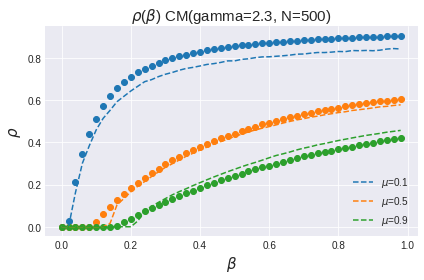

In [ ]:
for i in range(len(mu_list)):
    plt.plot(beta_list, values_per_mu[i], label=r'$\mu$' + '={}'.format(mu_list[i]), linestyle='dashed')
    plt.scatter(beta_list, values_per_mu_MMCA[i])
    plt.title(r'$\rho$($\beta$)' + ' ' + net_name, fontsize=15)
    plt.xlabel(r'$\beta$', fontsize=15)
    plt.ylabel(r'$\rho$', fontsize=15)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.style.use('seaborn-darkgrid')

    plt.savefig(f"{file_name}.png")

In [ ]:
import pickle

with open(file_name+'_real_mu.pickle', 'wb') as f:
  pickle.dump(mu_list, f)

with open(file_name+'_mmca_mu.pickle', 'wb') as f:
  pickle.dump(values_per_mu_MMCA, f)

with open(file_name+'_beta.pickle', 'wb') as f:
  pickle.dump(beta_list, f)